# TIME SERIES

A time series: a series of data points ordered in time. In a time series,we have only 2 variables, time & the variable we want to forecast for the future.

### IMPORT LIBRARIES / DATA

In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

AirPassengers data, available on Kaggle:

https://www.kaggle.com/rakannimer/air-passengers

(number of passengers per month in the US between 1949 and 1960)

In [123]:
os.listdir()
data = pd.read_csv('AirPassengers.csv',parse_dates = ["Month"])
data.rename(columns={'Month':'Time', '#Passengers':'Passengers'},inplace=True)
print(data.columns)
print(data.head(5))

Index(['Time', 'Passengers'], dtype='object')
        Time  Passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121


In [124]:
indexdata = data.set_index(['Time'])
indexdata.head(5)

,Passengers
Time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### RAW DATA

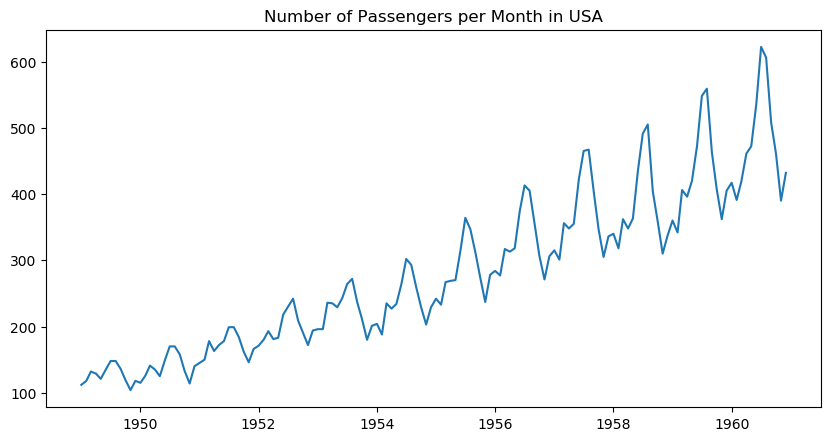

In [125]:
%matplotlib inline
plt.figure(figsize=(10,5), dpi=100)

plt.plot(data["Time"], data["Passengers"])
plt.title('Number of Passengers per Month in USA')
plt.show()

### TRANSFORMATION TO ACHIEVE STATIONARITY

- Trend - Upward & downward movement of the data with time over a large period of time
- Cyclicity - Behavior that repeats itself after large interval of time, like months, years 
- Seasonality - Seasonal variances
- Noise or Irregularity - Spikes & troughs at random intervals
- Stationarity - The mean, variance or standard deviation do not vary over time

Trend & Seasonality are two reasons why a Time Series is not stationary & hence need to be corrected.


In [126]:
rolmean = indexdata.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexdata.rolling(window=12).std()

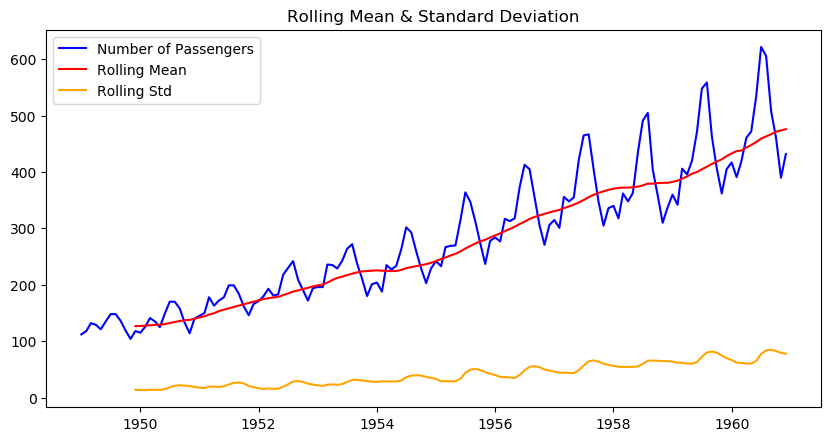

In [127]:
#Plot rolling statistics
plt.figure(figsize=(10,5), dpi=100)
plt.plot(indexdata, color='blue', label='Number of Passengers')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='orange', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Apply a logarithmic type transformation to achieve staionarity

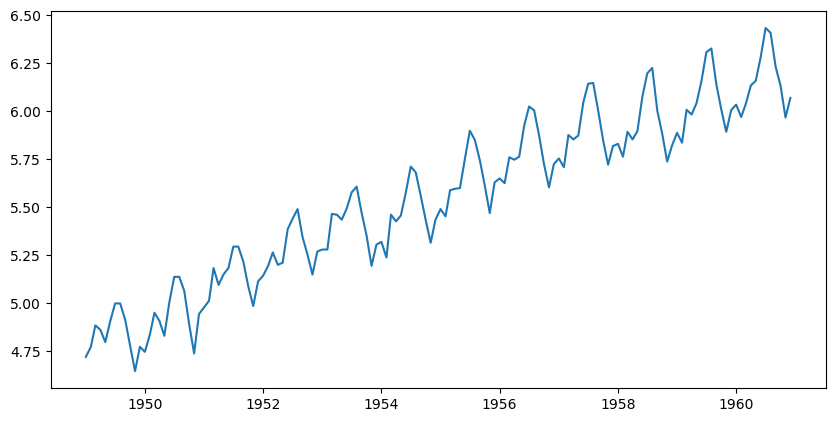

In [128]:
plt.figure(figsize=(10,5), dpi=100)

#data['LogPassengers'] = np.log(data['Passengers'])
#plt.plot(data["Time"], data['LogPassengers'])

indexdata['LogPassengers'] = np.log(indexdata)
plt.plot(indexdata['LogPassengers'])
plt.show()

Différentes méthodes permettent d'identifier la tendance d'une série chronologique, par exemple une régression polynomiale ou une moyenne mobile. Nous utiliserons la moyenne mobile pour tenter d'illustrer la tendance dans l'évolution du nombre de passagers.

In [129]:
indexdata.columns

Index(['Passengers', 'LogPassengers'], dtype='object')

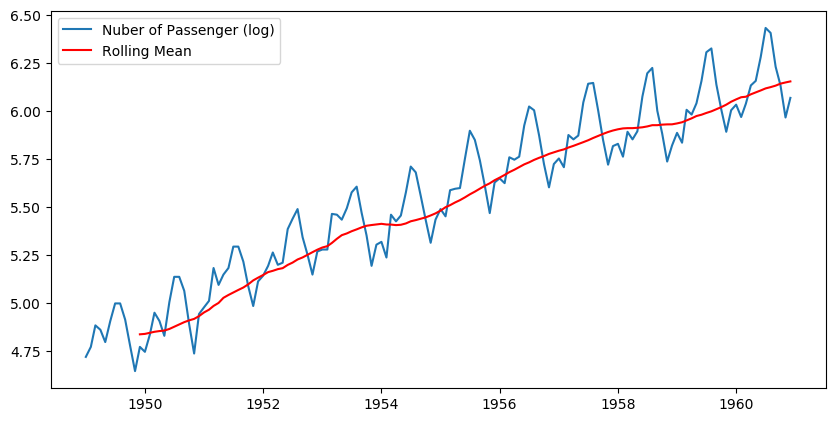

In [130]:
plt.figure(figsize=(10,5), dpi=100)

#The below transformation is required to make series stationary
rolmean2 = indexdata['LogPassengers'].rolling(window=12).mean()
rolstd2 = indexdata['LogPassengers'].rolling(window=12).std()

plt.plot(indexdata['LogPassengers'],label='Nuber of Passenger (log)')
plt.plot(rolmean2, color='red', label="Rolling Mean")



plt.legend()
plt.show()

Seasonality can then be estimated by calculating the difference between observed data and the trend (moving average in this case)

In [131]:
avg_diff = indexdata['LogPassengers'] - rolmean2
avg_diff.head(24)

Time
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
Name: LogPassengers, dtype: float64

In [132]:
#Remove NAN values
avg_diff.dropna(inplace=True)
avg_diff.head(10)

Time
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
Name: LogPassengers, dtype: float64

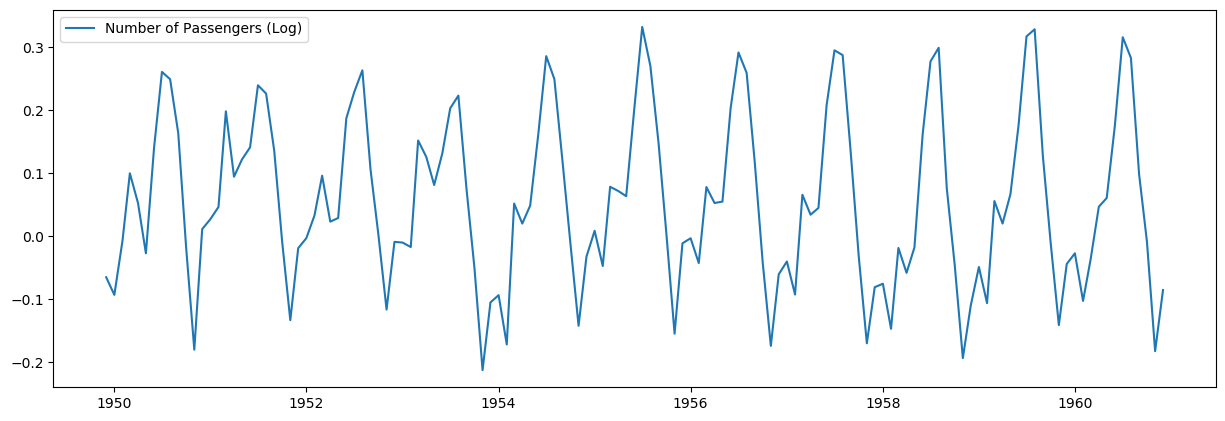

In [133]:
plt.figure(figsize=(15,5), dpi=100)

plt.plot(avg_diff, label = 'Number of Passengers (Log)')
plt.legend()
plt.show()

## In Python it is also possible to use a decomposition function from the stats library

C:\Users\kimku\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1000x2000 with 0 Axes>

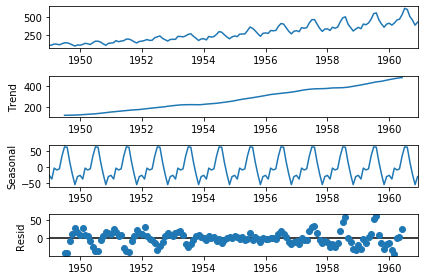

In [134]:
serie = data.set_index("Time")

decomposition = seasonal_decompose(serie, model ='additive', freq=12)

plt.figure(figsize=(10,20), dpi=100)
decomposition.plot()

plt.show()

### Stationarity

We can visually notice that the average is not constant and that the series has a strong seasonality. We can therefore say that the series seems far from being stationary or that it presents a weak stationarity. The Dickey-Fuller augmented test makes it possible to test the stationarity of a series in a more formal way. This test is available in the stats library.

In [135]:
result = adfuller(data['Passengers'])
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


For a Time series to be stationary, its ADF test should have:
p-value to be low (according to the null hypothesis)

The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series is not stationary

## Time Shift Transformation

1st Differencing
ADF Statistic: -2.717131
p-value: 0.071121


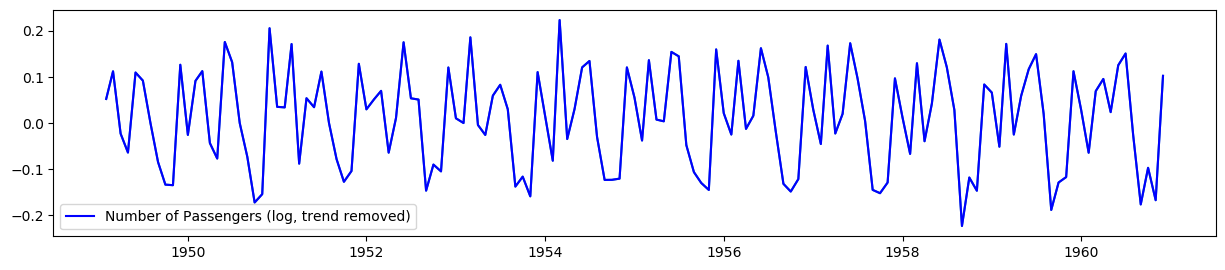

In [136]:
# Try to achieve Stationarity

plt.figure(figsize=(15,3), dpi=100)

datasetLogDiffShifting = indexdata['LogPassengers'] - indexdata['LogPassengers'].shift()
plt.plot(datasetLogDiffShifting)
datasetLogDiffShifting.dropna(inplace=True)

result = adfuller(datasetLogDiffShifting)

print("1st Differencing")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

plt.plot(datasetLogDiffShifting, color='blue',label = 'Number of Passengers (log, trend removed)')
plt.legend()
plt.show()

# Forecast with ARIMA
-Review the Models

### I) Auto-regressive or auto-regression (AR) model:

Autoregressive process predicts the future value based on its past values.
It can be - but not exclusively - a linear regression model. Auto-regression is used in time series prediction, in which the past values of the dependent variable are used to predict future values of the dependent variabl

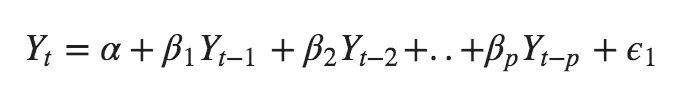

In [137]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(data = "images/ARmodel.png")

### II) Moving average model - Moving Average (MA)

The Moving Average model is a prediction model in which Y depends not on past values but also on deferred prediction errors.


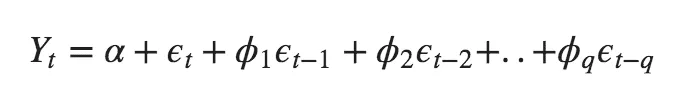

In [138]:
Image(data = "images/MAmodel.png")

In the Moving Average model, the deferred prediction errors correspond to the errors of the linear auto regressive model (Auto Regressive Model) seen previously. Thus the error terms Et and Et-1 come from the following equations.

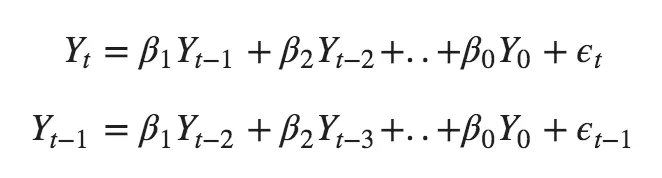

In [139]:
Image(data = "images/ARmodel2.png")

### III) AR-MA - (Autoregressive – moving-average model)
ARMA is a combination of two models: the auto-regressive (AR) model and the moving average (MA).
It is based on the following two parameters:

p = number of periods (lags) used in the autoregressive process
q = number of periods in the moving average

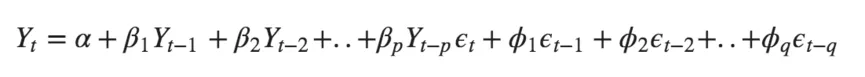

In [140]:
Image(data = "images/ARMAmodel.png")

### IV) ARIMA

Like ARMA, ARIMA combines auto-regression and moving average, but it also contains an integration parameter (differencing).


 ARIMA therefore has three parameters: p, d and q

- p = number of periods (lags) used in the autoregressive process
- d = number of integration (differencing) necessary to make the series stationary
- q = number of periods in the moving average

### Determine the parameters p and q visually

AUTOCORRELATION


Autocorrelation represents the correlation between the independent value at time t Vt and the previous values ​​of V: ​​Vt-1, Vt-2 etc.
The autocorrelation between Vt and Vt-n includes both the direct effect of Vt-n on Vt and the indirect effect ie. the effect of all intermediate values of V between t-n and t.


In [141]:
sample = pd.DataFrame()
sample['T'] =   ['Mar', 'Apr', 'May', 'Jun','Jul','Aug']
sample['T-1'] = ['Feb','Mar', 'Apr', 'May', 'Jun','Jul']
sample['T-2'] = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun']

sample

,T,T-1,T-2
0,Mar,Feb,Jan
1,Apr,Mar,Feb
2,May,Apr,Mar
3,Jun,May,Apr
4,Jul,Jun,May
5,Aug,Jul,Jun


PARTIAL AUTOCORRELATION

The partial autocorrelation captures only the direct effect of the Vt-n value on the current Vt value, excluding the effect of intermediate values periods.
It therefore corresponds to the beta term of the autoregressive model (AR) formula presented above.

- The PACF (Partial autocorrelation function) can help determine p (parameter for the AR part)
- The ACF (Autocorrelation) can help determine q (parameter for the MA part)

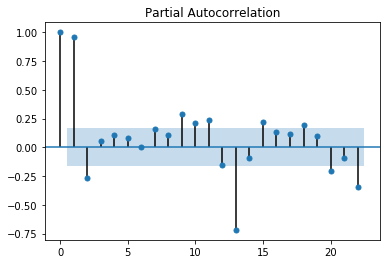

In [142]:
plot_pacf(data['Passengers'])
plt.show()

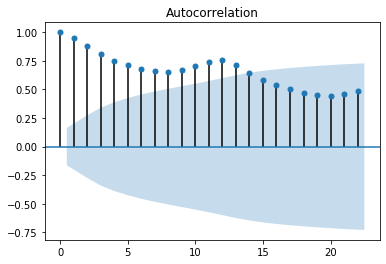

In [143]:
plot_acf(data['Passengers'])
plt.show()

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.715
Date:                Mon, 21 Sep 2020   AIC                           1344.043
Time:                        12:40:02   BIC                           1361.820
Sample:                             1   HQIC                          1351.267
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Passengers  

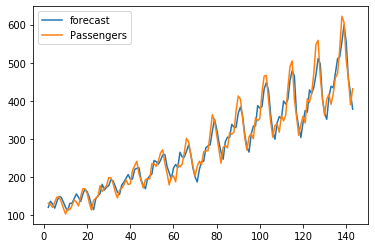

In [144]:
model = ARIMA(data['Passengers'], order=(2, 1, 2))  
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_predict(dynamic=False)
plt.show()

### Train a prediction model (plain vanilla)

In [145]:
input_data = data['Passengers']
input_data.shape

(144,)

In [146]:
train = input_data[:120]
test = input_data[120:]
landmark = len(test)

In [147]:
model = ARIMA(train, order=(2,1,2))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(landmark, alpha=0.05)  # 95% conf

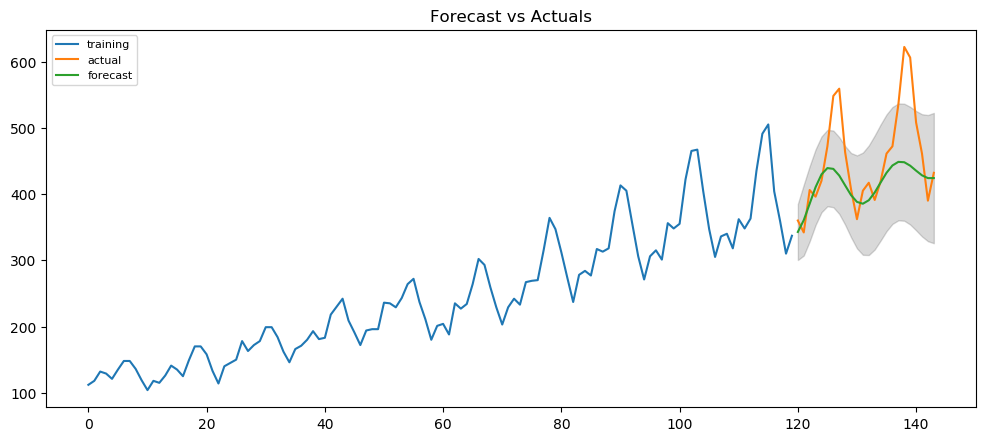

In [148]:
# Transformer la séquence en série pandas avec les dates correspondantes en index
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Using Log Scale and Reverse

In [149]:
indexdata.columns
indexedDataset_logScale=indexdata['LogPassengers']
indexedDataset_logScale.head(5)

Time
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: LogPassengers, dtype: float64

C:\Users\kimku\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kimku\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


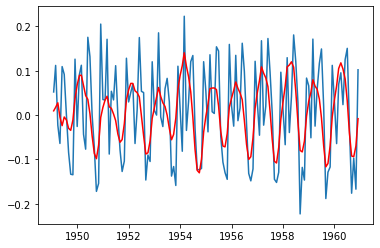

In [150]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')

print('Plotting ARIMA model')

In [151]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Time
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [152]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Time
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372553
1960-09-01    1.280203
1960-10-01    1.186190
1960-11-01    1.116267
1960-12-01    1.108140
Length: 143, dtype: float64


In [153]:
predictions_ARIMA_log = pd.Series(indexdata['LogPassengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Time
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

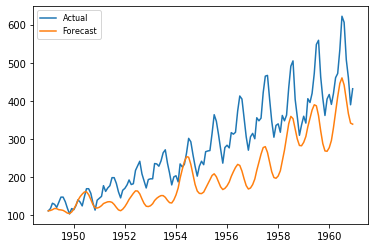

In [154]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset,label='Actual')
plt.plot(predictions_ARIMA,label='Forecast')
plt.legend(loc='upper left', fontsize=8)

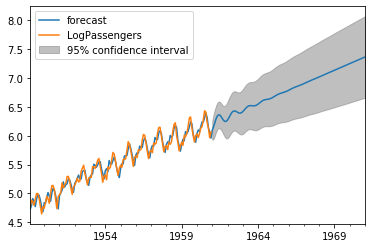

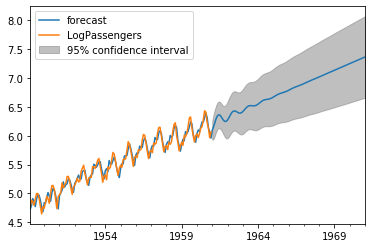

In [155]:
results_ARIMA.plot_predict(1,264) 

Time Series Test Ends Here